<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1>Practice: Neural Networks with One Hidden Layer: Noisy XOR</h1>


<h2>Objective</h2><p>After completing this lab you will be able to:</p> 
<ul><li> Create a neural network model with multiple neurons to model a simple function.</li></ul>


<h2>Table of Contents</h2>
<p>In this lab, you will see how many neurons it takes to classify noisy XOR data with one hidden layer neural network.</p>

<ul>
    <li><a href="#Model">Neural Network Module and Training Function</a></li>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#One">One Neuron</a></li>
    <li><a href="#Two">Two Neurons</a></li>
    <li><a href="#Three">Three Neurons</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>
<hr>


<h2>Preparation</h2>


We'll need the following libraries


In [1]:
!pip3 install torch torchvision torchaudio

In [2]:
# Import the libraries we need for this lab

# Allows us to use arrays to manipulate and store data
import numpy as np
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to use activation functions
import torch.nn.functional as F
# Used to graph data and loss curves
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
# Used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader

Use the following function to plot the data: 


In [3]:
# Plot the data

def plot_decision_regions_2class(model,data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')
    plt.title("decision region")
    plt.legend()

Use the following function to calculate accuracy: 


In [4]:
# Calculate the accuracy

def accuracy(model, data_set):
    # Rounds prediction to nearest integer 0 or 1
    # Checks if prediction matches the actual values and returns accuracy rate
    return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:, 0] > 0.5).numpy())

<!--Empty Space for separating topics-->


<h2 id="Model">Neural Network Module and Training Function</h2> 


Define the neural network module or class: 


In [5]:
# Define the class Net with one hidden layer 

class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        # D_in is the input size of the first layer (size of input layer)
        # H is the outpout size of the first layer and the input size of the second layer (size of hidden layer)
        # D_out is the output size of the second layer (size of output layer)
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    # Prediction    
    def forward(self, x):
        # Puts x through first layer then sigmoid function
        x = torch.sigmoid(self.linear1(x)) 
        # Puts result of previous line through second layer then sigmoid function
        x = torch.sigmoid(self.linear2(x))
        # Output is a number between 0 and 1 due to the sigmoid function. Whichever the output is closer to, 0 or 1, is the class prediction
        return x

Define a function to train the model: 


In [6]:
# Function to Train the Model

def train(data_set, model, criterion, train_loader, optimizer, epochs=5):
    # Lists to keep track of cost and accuracy
    COST = []
    ACC = []
    # Number of times we train on the entire dataset
    for epoch in range(epochs):
        # Total loss over epoch
        total=0
        # For batch in train laoder
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            yhat = model(x)
            # Measures the loss between prediction and acutal Y value
            loss = criterion(yhat, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss 
            total+=loss.item()
        # Saves cost and accuracy
        ACC.append(accuracy(model, data_set))
        COST.append(total)
        
    # Prints Cost vs Epoch graph
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    # Prints Accuracy vs Epoch graph
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

    return COST

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Make Some Data</h2> 


Dataset class:


In [7]:
# Define the class XOR_Data

class XOR_Data(Dataset):
    
    # Constructor
    # N_s is the size of the dataset
    def __init__(self, N_s=100):
        # Create a N_s by 2 array for the X values representing the coordinates
        self.x = torch.zeros((N_s, 2))
        # Create a N_s by 1 array for the class the X value belongs to
        self.y = torch.zeros((N_s, 1))
        # Split the dataset into 4 sections
        for i in range(N_s // 4):
            # Create data centered around (0,0) of class 0
            self.x[i, :] = torch.Tensor([0.0, 0.0]) 
            self.y[i, 0] = torch.Tensor([0.0])

            # Create data centered around (0,1) of class 1
            self.x[i + N_s // 4, :] = torch.Tensor([0.0, 1.0])
            self.y[i + N_s // 4, 0] = torch.Tensor([1.0])
    
            # Create data centered around (1,0) of class 1
            self.x[i + N_s // 2, :] = torch.Tensor([1.0, 0.0])
            self.y[i + N_s // 2, 0] = torch.Tensor([1.0])
    
            # Create data centered around (1,1) of class 0
            self.x[i + 3 * N_s // 4, :] = torch.Tensor([1.0, 1.0])
            self.y[i + 3 * N_s // 4, 0] = torch.Tensor([0.0])

            # Add some noise to the X values to make them different
            self.x = self.x + 0.01 * torch.randn((N_s, 2))
        self.len = N_s

    # Getter
    def __getitem__(self, index):    
        return self.x[index],self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot_stuff(self):
        plt.plot(self.x[self.y[:, 0] == 0, 0].numpy(), self.x[self.y[:, 0] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:, 0] == 1, 0].numpy(), self.x[self.y[:, 0] == 1, 1].numpy(), 'ro', label="y=1")
        plt.legend()

Dataset object:


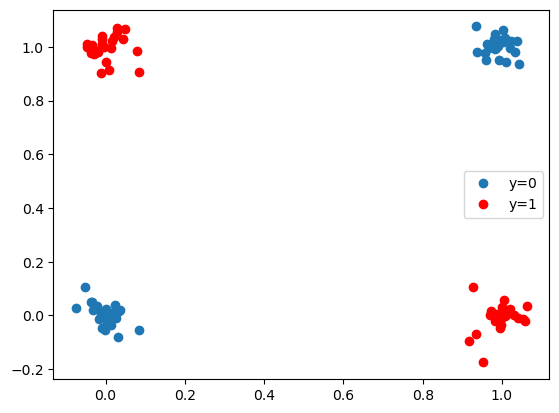

In [8]:
# Create dataset object

data_set = XOR_Data()
data_set.plot_stuff()

<!--Empty Space for separating topics-->


<h2 id="One">One Neuron</h2> 


Create a neural network <code>model</code> with one neuron in the hidden layer. Then, use the following code to train it:


In [12]:
model = Net(2, 1, 1)

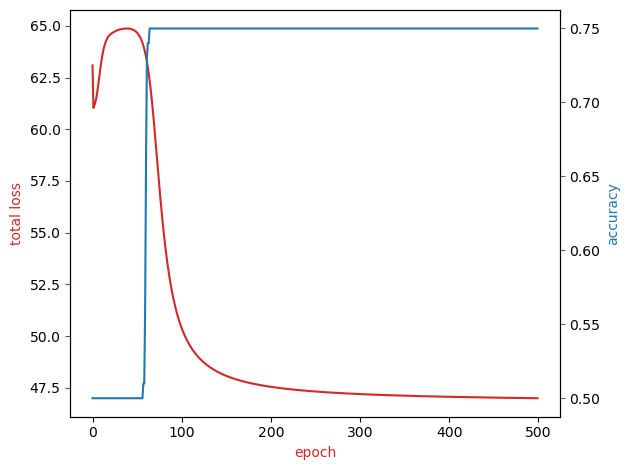

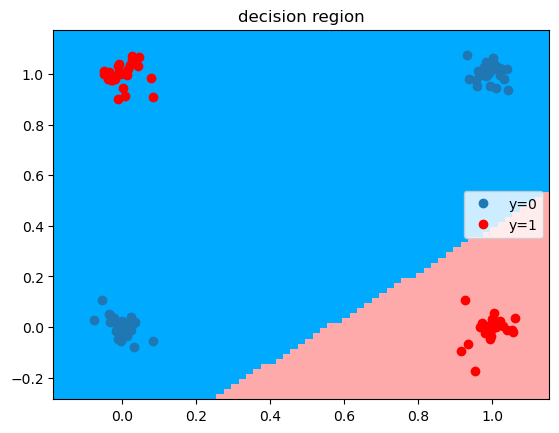

In [13]:
# Train the model

learning_rate = 0.1
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Create a Data Loader for the training data with a batch size of 1 
train_loader = DataLoader(dataset=data_set, batch_size=1)
# Using the training function train the model on 500 epochs
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
# Plot the data with decision boundaries
plot_decision_regions_2class(model, data_set)

<!--Empty Space for separating topics-->


<h2 id="Two">Two Neurons</h2> 


Create a neural network <code>model</code> with two neurons in the hidden layer. Then, use the following code to train it:


In [15]:
model = Net(2, 2, 1)

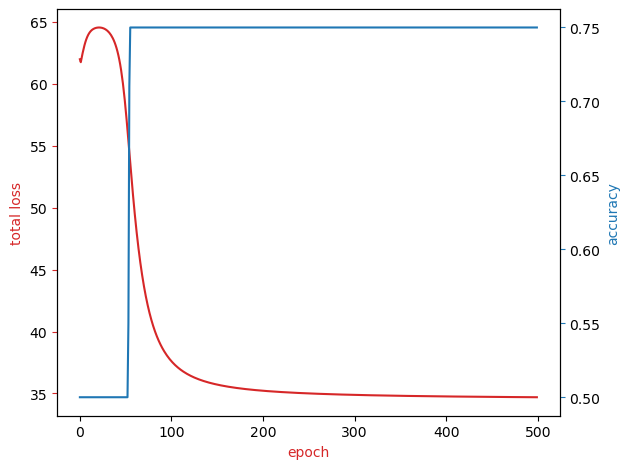

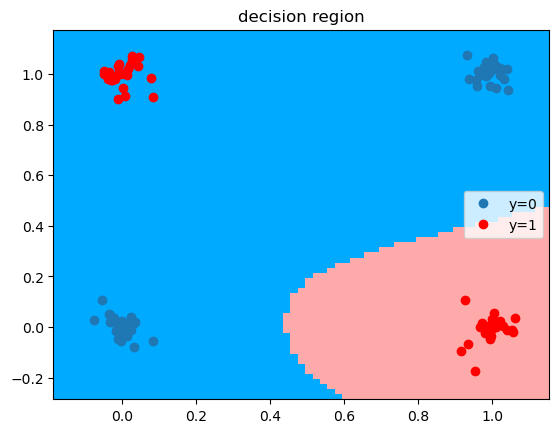

In [16]:
# Train the model

learning_rate = 0.1
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# Create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Create a Data Loader for the training data with a batch size of 1 
train_loader = DataLoader(dataset=data_set, batch_size=1)
# Using the training function train the model on 500 epochs
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
# Plot the data with decision boundaries
plot_decision_regions_2class(model, data_set)

<!--Empty Space for separating topics-->


<h2 id="Three">Three Neurons</h2> 


<h3>Try</h3>


Create a neural network <code>model</code> with three neurons in the hidden layer. Then, use the following code to train it:


In [17]:
model = Net(2, 3, 1)

Double-click <b>here</b> for the solution.

<!-- 
model = Net(2, 3, 1)
-->


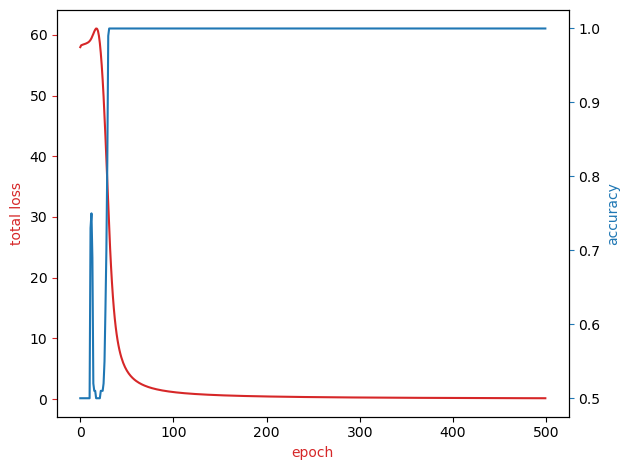

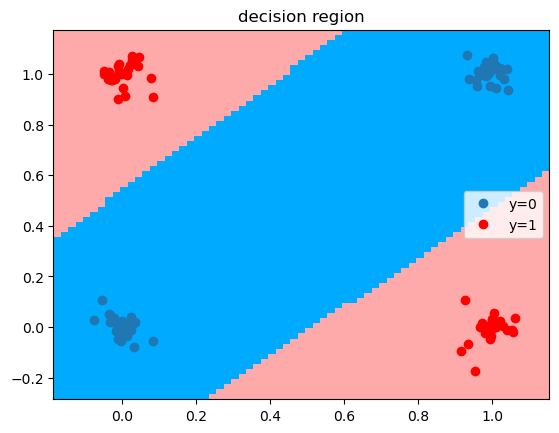

In [18]:
# Train the model

learning_rate = 0.1
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# Create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Create a Data Loader for the training data with a batch size of 1 
train_loader = DataLoader(dataset=data_set, batch_size=1)
# Using the training function train the model on 500 epochs
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
# Plot the data with decision boundaries
plot_decision_regions_2class(model, data_set)

<hr>



## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
